In [21]:
import fasttext
import fasttext.util

In [ ]:


# Download English model (.bin format)
fasttext.util.download_model('en', if_exists='ignore')  # Downloads cc.en.300.bin
ft_en = fasttext.load_model('cc.en.300.bin')

# Save top 100,000 English words to .vec file
top_k = 100000
en_words = ft_en.get_words()[:top_k]

with open('en_top100k.vec', 'w', encoding='utf-8') as f:
    for word in en_words:
        vector = ft_en.get_word_vector(word)
        vector_str = ' '.join(map(str, vector))
        f.write(f"{word} {vector_str}\n")


In [ ]:
# Download Hindi model
fasttext.util.download_model('hi', if_exists='ignore')  # Downloads cc.hi.300.bin
ft_hi = fasttext.load_model('cc.hi.300.bin')

# Save top 100,000 Hindi words to .vec file
top_k = 100000
hi_words = ft_hi.get_words()[:top_k]

with open('hi_top100k.vec', 'w', encoding='utf-8') as f:
    for word in hi_words:
        vector = ft_hi.get_word_vector(word)
        vector_str = ' '.join(map(str, vector))
        f.write(f"{word} {vector_str}\n")


#### Load English and Hindi Vocab Sets

In [9]:
# Create English vocab set
en_vocab = set()
with open('../data/fasttext_pretrained_vectors/en_top100k.vec', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) > 1:
            word = parts[0]
            en_vocab.add(word)

# Create Hindi vocab set
hi_vocab = set()
with open('../data/fasttext_pretrained_vectors/hi_top100k.vec', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) > 1:
            word = parts[0]
            hi_vocab.add(word)


#### Load and Filter the MUSE Dictionary

In [10]:
# Path to original MUSE bilingual dictionary
muse_dict_path = '../data/muse_bilingual_dictionary/en-hi.txt'  # Update if needed

# Save only valid pairs to this file
filtered_dict_path = '../data/muse_bilingual_dictionary/valid_pairs.txt'

with open(muse_dict_path, 'r', encoding='utf-8') as f_in, open(filtered_dict_path, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        en_word, hi_word = parts[0], parts[1]
        if en_word in en_vocab and hi_word in hi_vocab:
            f_out.write(f"{en_word} {hi_word}\n")


#### Split Valid Pairs into Train/Test

In [11]:
# Read all valid pairs into a list
with open('../data/muse_bilingual_dictionary/valid_pairs.txt', 'r', encoding='utf-8') as f:
    all_pairs = [line.strip().split() for line in f if len(line.strip().split()) == 2]

# Shuffle the list (important for randomness)
import random
random.shuffle(all_pairs)

# Split into train (80%) and test (20%)
split_index = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:split_index]
test_pairs = all_pairs[split_index:]

# Save them to separate files
with open('../data/train_pairs.txt', 'w', encoding='utf-8') as f:
    for en, hi in train_pairs:
        f.write(f"{en} {hi}\n")

with open('../data/test_pairs.txt', 'w', encoding='utf-8') as f:
    for en, hi in test_pairs:
        f.write(f"{en} {hi}\n")


####  Load Embeddings Again for Lookup

In [12]:
# Load English embeddings into a dictionary
en_vectors = {}
with open('../data/fasttext_pretrained_vectors/en_top100k.vec', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 301:
            word = parts[0]
            vec = list(map(float, parts[1:]))
            en_vectors[word] = vec

# Load Hindi embeddings into a dictionary
hi_vectors = {}
with open('../data/fasttext_pretrained_vectors/hi_top100k.vec', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 301:
            word = parts[0]
            vec = list(map(float, parts[1:]))
            hi_vectors[word] = vec


#### Extract Matrices X and Y from train_pairs

In [13]:
# Extract vectors from train_pairs
X = []  # English vectors
Y = []  # Hindi vectors

for en_word, hi_word in train_pairs:
    if en_word in en_vectors and hi_word in hi_vectors:
        X.append(en_vectors[en_word])
        Y.append(hi_vectors[hi_word])

# Convert to NumPy arrays
import numpy as np

X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)  # Should be (N, 300)
print("Y shape:", Y.shape)


X shape: (15177, 300)
Y shape: (15177, 300)


### Procrustes Alignment

#### Normalize X and Y

In [14]:
# Normalize each row vector in X and Y
from numpy.linalg import norm

X_norm = X / norm(X, axis=1, keepdims=True)
Y_norm = Y / norm(Y, axis=1, keepdims=True)


#### Compute Procrustes Alignment

In [15]:
# Compute the Procrustes alignment using SVD
import scipy

# Compute cross-covariance matrix
M = Y_norm.T @ X_norm

# SVD decomposition
U, _, Vt = np.linalg.svd(M)

# Compute the orthogonal matrix W
W = U @ Vt

# Align Hindi embeddings
Y_aligned = Y_norm @ W


#### Check Orthogonality

In [16]:
# W should be orthogonal: W.T @ W ≈ Identity matrix
check = W.T @ W
print("Should be close to identity:")
print(check[:5, :5]) 


Should be close to identity:
[[ 1.00000000e+00 -1.83880688e-16  7.11236625e-17  2.78423118e-16
  -1.04083409e-16]
 [-1.83880688e-16  1.00000000e+00  1.45716772e-16  9.02056208e-17
  -1.04083409e-17]
 [ 7.11236625e-17  1.45716772e-16  1.00000000e+00 -6.24500451e-17
  -2.04697370e-16]
 [ 2.78423118e-16  9.02056208e-17 -6.24500451e-17  1.00000000e+00
  -4.03323208e-17]
 [-1.04083409e-16 -1.04083409e-17 -2.04697370e-16 -4.03323208e-17
   1.00000000e+00]]


### Evaluation

#### Prepare Test Dictionary Vectors

In [17]:
# Load test word pairs (created earlier)
test_pairs = []
with open('../data/test_pairs.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            test_pairs.append((parts[0], parts[1]))


#### Prepare Aligned Hindi Vocabulary Matrix for Search

In [18]:
# Build a lookup matrix and list of words for nearest neighbor search
aligned_hindi_words = list(hi_vectors.keys())  # Already filtered in Task 1
aligned_hindi_vecs = []

for word in aligned_hindi_words:
    if word in hi_vectors:
        vec = np.array(hi_vectors[word])
        vec = vec / np.linalg.norm(vec)  # normalize
        aligned_vec = vec @ W            # apply Procrustes transform
        aligned_hindi_vecs.append(aligned_vec)

aligned_hindi_vecs = np.array(aligned_hindi_vecs)  # shape (V, 300)


#### Translation & Precision Evaluation

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

top1_correct = 0
top5_correct = 0
total = 0

for en_word, true_hi_word in test_pairs:
    if en_word not in en_vectors or true_hi_word not in hi_vectors:
        continue

    en_vec = np.array(en_vectors[en_word])
    en_vec = en_vec / np.linalg.norm(en_vec)

    similarities = cosine_similarity(en_vec.reshape(1, -1), aligned_hindi_vecs)[0]
    top_indices = np.argsort(similarities)[::-1]  # sorted high → low

    top_5_words = [aligned_hindi_words[i] for i in top_indices[:5]]

    total += 1
    if true_hi_word == top_5_words[0]:
        top1_correct += 1
    if true_hi_word in top_5_words:
        top5_correct += 1

# Compute precision
precision_at_1 = top1_correct / total
precision_at_5 = top5_correct / total

print("Precision@1:", round(precision_at_1, 4))
print("Precision@5:", round(precision_at_5, 4))


Precision@1: 0.2664
Precision@5: 0.5159


#### Cosine Similarity Distribution

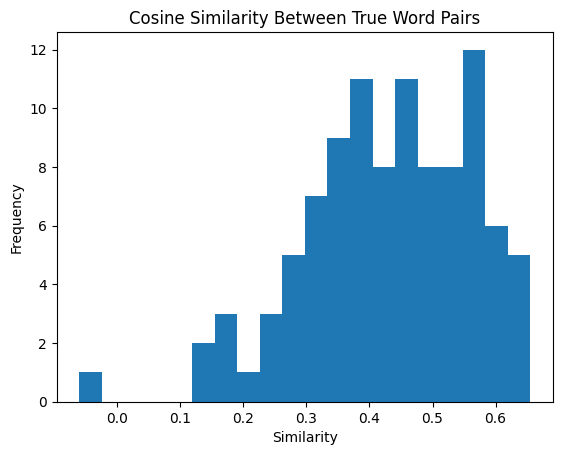

In [19]:
# Compute cosine similarity for a few matched pairs
import matplotlib.pyplot as plt

scores = []
for en_word, hi_word in random.sample(test_pairs, 100):  # sample 100
    if en_word in en_vectors and hi_word in hi_vectors:
        en_vec = np.array(en_vectors[en_word])
        hi_vec = np.array(hi_vectors[hi_word])
        hi_vec = hi_vec / np.linalg.norm(hi_vec)
        hi_vec = hi_vec @ W
        en_vec = en_vec / np.linalg.norm(en_vec)
        sim = np.dot(en_vec, hi_vec)
        scores.append(sim)

plt.hist(scores, bins=20)
plt.title("Cosine Similarity Between True Word Pairs")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()


In [20]:
# List of English words you want to test
words_to_test = ["water", "king", "love", "book", "mother", "school"]

for en_word in words_to_test:
    print("English word:", en_word)

    if en_word not in en_vectors:
        print("Not found in English vocabulary.\n")
        continue

    # Get and normalize English vector
    en_vec = np.array(en_vectors[en_word])
    en_vec = en_vec / np.linalg.norm(en_vec)

    # Compute cosine similarity with all aligned Hindi vectors
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(en_vec.reshape(1, -1), aligned_hindi_vecs)[0]

    # Get top 5 closest Hindi words
    top_indices = np.argsort(similarities)[::-1][:5]
    
    print("Top 5 Hindi translations:")
    for i, idx in enumerate(top_indices):
        print(f"   {i+1}. {aligned_hindi_words[idx]}")
    
    print("")  # Blank line between results


English word: water
Top 5 Hindi translations:
   1. पानी
   2. पीने
   3. हैण्डपम्प
   4. भूजल
   5. खारापन

English word: king
Top 5 Hindi translations:
   1. राजा
   2. बादशाह
   3. शाहजादा
   4. राजकुमार
   5. सिंहासन

English word: love
Top 5 Hindi translations:
   1. प्यार
   2. प्रेम
   3. पसंद
   4. किसीसे
   5. प्‍यार

English word: book
Top 5 Hindi translations:
   1. पुस्तक
   2. किताब
   3. किताबें
   4. बुक
   5. पुस्तकों

English word: mother
Top 5 Hindi translations:
   1. मां
   2. पिता
   3. माँ
   4. बेटी
   5. माता

English word: school
Top 5 Hindi translations:
   1. स्कूल
   2. स्कूलों
   3. विद्यालय
   4. कॉलेज
   5. पढ़ाई



### Ablation Study – Impact of Dictionary Size

#### Prepare Multiple Training Sets

In [ ]:
# From the earlier shuffled valid_pairs list (used in train/test split)
subset_5k = train_pairs[:5000]
subset_10k = train_pairs[:10000]
subset_20k = train_pairs[:20000]

# Save to files
with open('./Cross-Lingual-Word-Embedding-Alignment/evaluation/precision_scores/train_5k.txt', 'w', encoding='utf-8') as f:
    for en, hi in subset_5k:
        f.write(f"{en} {hi}\n")

with open('./Cross-Lingual-Word-Embedding-Alignment/evaluation/precision_scores/train_10k.txt', 'w', encoding='utf-8') as f:
    for en, hi in subset_10k:
        f.write(f"{en} {hi}\n")

with open('./Cross-Lingual-Word-Embedding-Alignment/evaluation/precision_scores/train_20k.txt', 'w', encoding='utf-8') as f:
    for en, hi in subset_20k:
        f.write(f"{en} {hi}\n")


#### Loop Through Each Set and Record P@1, P@5

In [18]:
# Dictionary sizes to test
sizes = [5000, 10000, 20000]

# Store results for comparison
results = []

for size in sizes:
    print("Running ablation for size:", size)

    # Load current training dictionary
    current_train_file = f'train_{size//1000}k.txt'
    current_train_pairs = []

    with open(current_train_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                current_train_pairs.append((parts[0], parts[1]))

    # Build X and Y matrices
    X = []
    Y = []

    for en_word, hi_word in current_train_pairs:
        if en_word in en_vectors and hi_word in hi_vectors:
            X.append(en_vectors[en_word])
            Y.append(hi_vectors[hi_word])

    import numpy as np
    X = np.array(X)
    Y = np.array(Y)

    # Normalize
    from numpy.linalg import norm
    X_norm = X / norm(X, axis=1, keepdims=True)
    Y_norm = Y / norm(Y, axis=1, keepdims=True)

    # Procrustes alignment
    M = Y_norm.T @ X_norm
    U, _, Vt = np.linalg.svd(M)
    W = U @ Vt
    Y_aligned = Y_norm @ W

    # Evaluate on test_pairs
    top1 = 0
    top5 = 0
    total = 0

    # Rebuild aligned Hindi vocab matrix (only once per run)
    aligned_hindi_words = list(hi_vectors.keys())
    aligned_hindi_vecs = []

    for word in aligned_hindi_words:
        vec = np.array(hi_vectors[word])
        vec = vec / np.linalg.norm(vec)
        aligned_vec = vec @ W
        aligned_hindi_vecs.append(aligned_vec)

    aligned_hindi_vecs = np.array(aligned_hindi_vecs)

    # Evaluate test_pairs
    from sklearn.metrics.pairwise import cosine_similarity

    for en_word, true_hi_word in test_pairs:
        if en_word not in en_vectors or true_hi_word not in hi_vectors:
            continue

        en_vec = np.array(en_vectors[en_word])
        en_vec = en_vec / np.linalg.norm(en_vec)
        similarities = cosine_similarity(en_vec.reshape(1, -1), aligned_hindi_vecs)[0]
        top_indices = np.argsort(similarities)[::-1][:5]
        top_words = [aligned_hindi_words[i] for i in top_indices]

        total += 1
        if true_hi_word == top_words[0]:
            top1 += 1
        if true_hi_word in top_words:
            top5 += 1

    # Calculate precision
    p1 = top1 / total
    p5 = top5 / total

    results.append((size, p1, p5))

    print(f" Size {size}: P@1 = {round(p1, 4)}, P@5 = {round(p5, 4)}\n")


🔁 Running ablation for size: 5000
✅ Size 5000: P@1 = 0.2485, P@5 = 0.4872

🔁 Running ablation for size: 10000
✅ Size 10000: P@1 = 0.2593, P@5 = 0.5051

🔁 Running ablation for size: 20000
✅ Size 20000: P@1 = 0.2664, P@5 = 0.5159



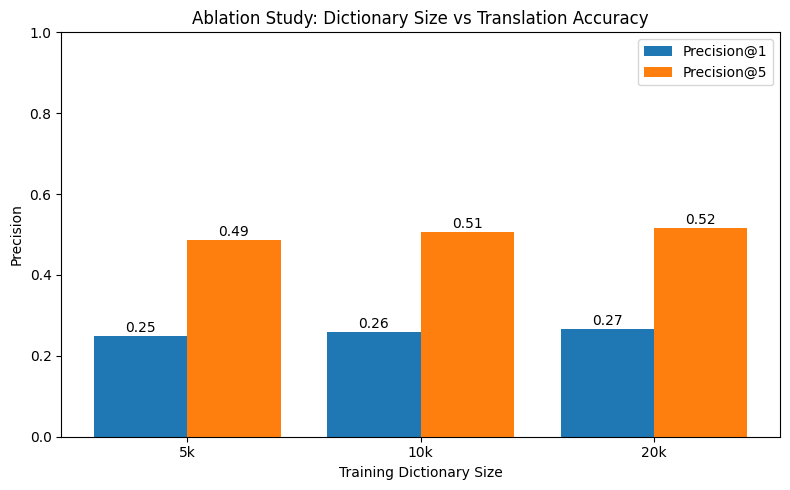

In [19]:
results = [
    (5000, 0.2485, 0.4872),
    (10000, 0.2593, 0.5051),
    (20000, 0.2664, 0.5159)
]
import matplotlib.pyplot as plt

# Extract data
sizes = [r[0] for r in results]
p1_scores = [r[1] for r in results]
p5_scores = [r[2] for r in results]

x = range(len(sizes))

# Create bar chart
plt.figure(figsize=(8, 5))
bar1 = plt.bar([i - 0.2 for i in x], p1_scores, width=0.4, label='Precision@1')
bar2 = plt.bar([i + 0.2 for i in x], p5_scores, width=0.4, label='Precision@5')

# Add labels
plt.xticks(x, [f"{s//1000}k" for s in sizes])
plt.ylabel("Precision")
plt.xlabel("Training Dictionary Size")
plt.title("Ablation Study: Dictionary Size vs Translation Accuracy")
plt.ylim(0, 1)
plt.legend()

# Show values on top of bars
for i in range(len(sizes)):
    plt.text(i - 0.2, p1_scores[i] + 0.01, f"{p1_scores[i]:.2f}", ha='center')
    plt.text(i + 0.2, p5_scores[i] + 0.01, f"{p5_scores[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()


## Unsupervised Alignment

### Load embeddings into memory

In [ ]:
import numpy as np

# Load English embeddings
en_vectors = {}
with open("./MUSE/data/vec/wiki.en.vec", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.strip().split()
        if len(parts) == 301:
            word = parts[0]
            vec = np.array([float(x) for x in parts[1:]])
            en_vectors[word] = vec

# Load Hindi embeddings
hi_vectors = {}
with open("./MUSE/data/vec/wiki.hi.vec", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.strip().split()
        if len(parts) == 301:
            word = parts[0]
            vec = np.array([float(x) for x in parts[1:]])
            hi_vectors[word] = vec


### Load the test dictionary

In [ ]:
test_pairs = []
with open("./data/test_pairs.txt", "r", encoding="utf-8") as f:
    for line in f:
        en, hi = line.strip().split()
        if en in en_vectors and hi in hi_vectors:
            test_pairs.append((en, hi))

print("Total test pairs:", len(test_pairs))


### Load the unsupervised transformation matrix W

In [ ]:
import torch

# Load the unsupervised mapping matrix from .pth
path = "./MUSE/checkpoints/unsup_en_hi/ch8boo17ue/unsup_en_hi/best_mapping.pth"
state = torch.load(path, map_location=torch.device("cpu"), weights_only=False)
W_unsup_tensor = state["mapping"].weight.data 
W_unsup = W_unsup_tensor.cpu().numpy()         




#### Transform Hindi vectors using W_unsup

In [ ]:
aligned_hi_vectors = {}

for word, vec in hi_vectors.items():
    norm_vec = vec / np.linalg.norm(vec)
    aligned_vec = np.dot(vec / np.linalg.norm(vec), W_unsup)
    aligned_hi_vectors[word] = aligned_vec


#### Evaluate Precision@1 and @5

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

top1 = 0
top5 = 0
total = 0

aligned_words = list(aligned_hi_vectors.keys())
aligned_matrix = np.array([aligned_hi_vectors[w] for w in aligned_words])

for en_word, hi_word in test_pairs:
    if en_word not in en_vectors or hi_word not in aligned_hi_vectors:
        continue

    en_vec = en_vectors[en_word]
    en_vec = en_vec / np.linalg.norm(en_vec)

    sim_scores = cosine_similarity(en_vec.reshape(1, -1), aligned_matrix)[0]
    top_indices = np.argsort(sim_scores)[::-1][:5]
    top_preds = [aligned_words[i] for i in top_indices]

    total += 1
    if hi_word == top_preds[0]:
        top1 += 1
    if hi_word in top_preds:
        top5 += 1

p1 = top1 / total
p5 = top5 / total

print("Unsupervised Evaluation")
print(f"Precision@1: {p1:.4f}")
print(f"Precision@5: {p5:.4f}")
